In [249]:
%matplotlib inline
#import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
#from pandas_datareader import data as pdr
#from bs4 import BeautifulSoup

# Задание 1.

Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Волшебный белый порошок" (ВБП), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на ВБП. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Дополнительные вводные:

Так как продукт Б новый, возможно стоит предложить дисконт от цены Продукта А. Продукт производиться из нефти. Один из известных способов производства предполагает что из 16 баррелей нефти сделают одну тонну ВБП, а затраты на производство в районе 400 евро.

In [250]:
# Из данных есть:
# Цены на продукт А, который уже есть на рынке Европы
# ----- октябрь 2018 - 
# ----- ноябрь 2018 - 
# ----- февраль 2019 -

# Котировки нефти, курс eur/usd
dbc = pd.read_excel('cur_oil.xlsx')

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками. 
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

#### Задание 1.
1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
 - Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
 - Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf) с именем клиента…

In [251]:
#1.Проанализировать имеющиеся данные.
#2.Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических
#данных.


class MagicWhitePowder:
        """Формула расчета цены на продукт"""
        
        def __init__(self):
            self.PRODUCTION_COST = 400
            self.EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
            self.CN_LOGISTIC_COST_USD = 130 # в Китай в долларах
        
        def logistic_cost (self, region, EUR_USD):
            if region == 'EU':
                cost = self.EU_LOGISTIC_COST_EUR
            elif  region == 'CN':
                cost = self.CN_LOGISTIC_COST_USD / EUR_USD
            return cost
        
        def FCA(self, oil_price, EUR_USD):
            """Расчет цены на заводе"""
            FCA = 16 * oil_price / EUR_USD + self.PRODUCTION_COST  
            return FCA    
        
        def DDP(self, oil_price, EUR_USD, region):
            """Расчет цены c доставкой для клиента"""
            DDP = self.FCA(oil_price, EUR_USD) +  self.logistic_cost(region, EUR_USD)
            return DDP

,Date,EURUSD=X,OIL,FCA,DDP
1,2018-01-02,1.2012,59.15,1187.878788,1217.878788
2,2018-01-03,1.2063,59.15,1184.547791,1214.547791
3,2018-01-04,1.2010,59.15,1188.009992,1218.009992
4,2018-01-05,1.2069,60.44,1201.259425,1231.259425
5,2018-01-08,1.2037,60.44,1203.389549,1233.389549


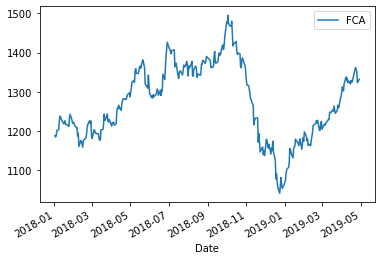

In [286]:
#3.Отобразить на графике.
#4.Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). 
#Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.

dbc = pd.read_excel('cur_oil.xlsx')
dbc.dropna(inplace=True)
mwp = MagicWhitePowder()

writer = pd.ExcelWriter('MWP_prices.xlsx', engine = 'xlsxwriter')

for key, value in customers.items():
    region = value['location']
    dbc['FCA'] = mwp.FCA(dbc['OIL'], dbc['EURUSD=X'])
    dbc['DDP'] = mwp.DDP(dbc['OIL'], dbc['EURUSD=X'], region)
    
    dbc.to_excel(writer, sheet_name = key)

writer.save()

#Отобразить цену FCA на графике.
dbc.plot(x='Date', y='FCA')
dbc.head(5)

### Расчет цены для подхода Moving Avarage

FCA = MA(Oil_price, window=5) * MA(EURUSD, window=5) * 16 + PRODUCTION_COST 

DDP = FCA + LOGISTIC_COST

In [289]:
#5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
# - Создать директорию «для клиентов» и в ней сложить файлы с расчетами.
# - Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf) с именем клиента…
dbc_ma = dbc.copy()

dbc_ma['EURUSD=X'] = dbc_ma['EURUSD=X'].rolling(window=5).mean()
dbc_ma['OIL']= dbc_ma['OIL'].rolling(window=5).mean()

dbc_mtha = dbc.copy()
dbc_mtha = dbc_mtha.set_index('Date').groupby(pd.Grouper(freq='M')).mean()  

for key, value in customers.items():
    writer = pd.ExcelWriter(f'{key}.xlsx', engine = 'xlsxwriter')
    region = value['location']
    meaning = value['comment']
    
    if meaning == 'moving_average':
        dbc_ma['FCA'] = mwp.FCA(dbc_ma['OIL'], dbc_ma['EURUSD=X'])
        dbc_ma['DDP'] = mwp.DDP(dbc_ma['OIL'], dbc_ma['EURUSD=X'], region)
        dbc_ma.to_excel(writer, sheet_name = key)
    elif meaning == 'monthly':
        dbc_mtha['FCA'] = mwp.FCA(dbc_mtha['OIL'], dbc_mtha['EURUSD=X'])
        dbc_mtha['DDP'] = mwp.DDP(dbc_mtha['OIL'], dbc_mtha['EURUSD=X'], region)
        dbc_mtha.to_excel(writer, sheet_name = key)

    writer.save()
#writer.close()

In [282]:
dbc_ma

,Date,EURUSD=X,OIL,FCA,DDP
1,2018-01-02,NaN,NaN,NaN,NaN
2,2018-01-03,NaN,NaN,NaN,NaN
3,2018-01-04,NaN,NaN,NaN,NaN
4,2018-01-05,NaN,NaN,NaN,NaN
5,2018-01-08,1.20382,59.666,1193.022213,1223.022213
...,...,...,...,...,...
341,2019-04-23,1.12782,66.228,1339.554184,1369.554184
342,2019-04-24,1.12620,66.524,1345.110993,1375.110993
343,2019-04-25,1.12356,66.760,1350.692442,1380.692442
344,2019-04-26,1.12036,66.530,1350.123175,1380.123175


In [174]:
excel_data_dbc= pd.read_excel('cur_oil.xlsx')
excel_data_dbc

,Date,EURUSD=X,OIL
0,2018-01-01,1.2005,NaN
1,2018-01-02,1.2012,59.15
2,2018-01-03,1.2063,59.15
3,2018-01-04,1.2010,59.15
4,2018-01-05,1.2069,60.44
...,...,...,...
341,2019-04-23,1.1259,67.72
342,2019-04-24,1.1224,67.14
343,2019-04-25,1.1153,66.37
344,2019-04-26,1.1137,64.27


# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [ ]:
# 

# Задание 3. Back to Russia

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать ВБП для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a>.


In [ ]:
# 

# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


In [ ]:
# 

# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

In [ ]:
# import yourpackage

# Задание 6. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

* Создайте отдельный пакет, который можно устанавливать с помощью pip 
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в репозиторий

In [ ]:
# !pip install yourpackage
# import yourpackage